In [2]:
import tensorflow as tf
import mitdeeplearning as mdl 
import numpy as np 
import matplotlib.pyplot as plt 

# Tensors 

In [4]:
# 0-d tensor
sport = tf.constant("Tennis", tf.string)
number = tf.constant(1.41421356237, tf.float64)

print("`sport` is a {}-d Tensor".format(tf.rank(sport).numpy()))
print("`number` is a {}-d Tensor".format(tf.rank(number).numpy()))

`sport` is a 0-d Tensor
`number` is a 0-d Tensor


In [6]:
# 1-d tensor
sports = tf.constant(["Tennis", "Basketball"], tf.string)
numbers = tf.constant([1.2, 3.2, 8.7], tf.float64)

print("`sports` is a {}-d Tensor with shape: {}".format(tf.rank(sports).numpy(), tf.shape(sports)))
print("`numbers` is a {}-d Tensor with shape: {}".format(tf.rank(numbers).numpy(), tf.shape(numbers)))

`sports` is a 1-d Tensor with shape: [2]
`numbers` is a 1-d Tensor with shape: [3]


In [7]:
# higher-order tensors
matrix = tf.constant([[1,2,3],[4,5,6]], tf.float64)

assert isinstance(matrix, tf.Tensor), "matrix must be a tf Tensor object"
assert tf.rank(matrix).numpy() == 2

In [9]:
# initial tensor with tf.zeros
images = tf.zeros((10, 256, 256, 3))

assert isinstance(images, tf.Tensor), "matrix must be a tf Tensor object"
assert tf.rank(images).numpy() == 4, "matrix must be of rank 4"
assert tf.shape(images).numpy().tolist() == [10, 256, 256, 3], "matrix is incorrect shape"

In [11]:
# tensor slicing
row_vector = matrix[1]
column_vector = matrix[:, 2]
scalar = matrix[1, 2]

print("`row_vector`: {}".format(row_vector.numpy()))
print("`column_vector`: {}".format(column_vector.numpy()))
print("`scalar`: {}".format(scalar.numpy()))

`row_vector`: [4. 5. 6.]
`column_vector`: [3. 6.]
`scalar`: 6.0


# Computations on Tensors 

In [12]:
a = tf.constant(15)
b = tf.constant(61)

c1 = tf.add(a, b)
c2 = a + b # tf overrides the operations, '+' -> tf.add()
print(c1)
print(c2)

tf.Tensor(76, shape=(), dtype=int32)
tf.Tensor(76, shape=(), dtype=int32)


In [14]:
def func(a, d):
    c = tf.add(a, b)
    d = tf.subtract(b, 1)
    e = tf.multiply(c, d)
    return e

a, b = 1.5, 2.5
e_out = func(a, b)
print(e_out) # a tensor, withour shape

tf.Tensor(6.0, shape=(), dtype=float32)


# Neural networks in Tensorflow 

In [19]:
class OurDenseLayer(tf.keras.layers.Layer):
    """
    n_output_nodes: number of output nodes
    input_shape: shape of the input
    x: input to the layer
    """
    def __init__(self, n_output_nodes):
        super(OurDenseLayer, self).__init__()
        self.n_output_nodes = n_output_nodes
        
    def build(self, input_shape):
        d = int(input_shape[-1])
        self.W = self.add_weight("weight", shape = [d, self.n_output_nodes])
        self.b = self.add_weight('bias', shape = [1, self.n_output_nodes])
        
    def call(self, x):
        z = tf.add(tf.matmul(x, self.W), self.b)
        y = tf.sigmoid(z)
        return y
    
# intialize parameters
tf.random.set_seed(1) # for re-produce
layer = OurDenseLayer(3)
layer.build((1, 2))
x_input = tf.constant([[1,2.]], shape=(1,2))
y = layer.call(x_input)

print(y.numpy())
mdl.lab1.test_custom_dense_layer_output(y)

[[0.26978594 0.45750415 0.66536945]]
[PASS] test_custom_dense_layer_output


True

In [20]:
# now use the tf build-in
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

n_output_nodes = 3
model = Sequential()
dense_layer = Dense(n_output_nodes)
model.add(dense_layer)

# now test it!
x_input = tf.constant([[1,2.]], shape=(1, 2))
model_output = model(x_input)
print(model_output)

tf.Tensor([[ 0.24415088  0.6485772  -1.9461871 ]], shape=(1, 3), dtype=float32)


In [21]:
# using subclass to define customized layers, train loops, activate function etc.
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

class SubclassModel(tf.keras.Model):
    def __init__(self, n_output_nodes):
        super(SubclassModel, self).__init__()
        self.dense_layer = Dense(n_output_nodes)
        
    # call function defines the forward path
    def call(self, inputs):
        return self.dense_layer(inputs)
    
# now test it again
n_output_nodes = 3
model = SubclassModel(n_output_nodes)
x_input = tf.constant([[1,2.]], shape=(1,2))
print(model.call(x_input))

tf.Tensor([[ 0.62118787 -0.08692831  1.6387595 ]], shape=(1, 3), dtype=float32)


In [22]:
# use boolean in call  
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

class SubclassModel(tf.keras.Model):
    def __init__(self, n_output_nodes):
        super(SubclassModel, self).__init__()
        self.dense_layer = Dense(n_output_nodes)
        
    # call function defines the forward path
    def call(self, inputs, isidentity= False):
        if not isidentity:
            return self.dense_layer(inputs)
        else:
            return inputs
    
# now test it again
n_output_nodes = 3
model = SubclassModel(n_output_nodes)
x_input = tf.constant([[1,2.]], shape=(1,2))

out_activate = model.call(x_input)
out_identity = model.call(x_input, isidentity=True)
print("Network output with activation: {}; network identity output: {}".format(out_activate.numpy(), out_identity.numpy()))

Network output with activation: [[-0.84747624  0.52264667 -0.06161666]]; network identity output: [[1. 2.]]


# Auto-differentiation in Tensorflow 

In [23]:
# tape is a record of a forward path
# y = x^2
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
    y = x * x
dy_dx = tape.gradient(y, x)

assert dy_dx.numpy() == 6.0

Initializing x=[0.9868413]


Text(0, 0.5, 'x value')

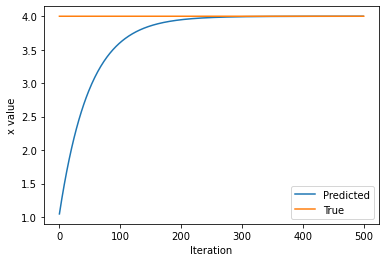

In [30]:
# auto-differentiation + SGD
x = tf.Variable(tf.random.normal([1]))
print("Initializing x={}".format(x.numpy()))

learning_rate = 1e-2
history = []
x_f = 4 # target value

for i in range(500):
    with tf.GradientTape() as tape:
        loss = tf.pow(tf.subtract(x, x_f), 2)
        # loss = (x - x_f) ** 2 is also okay
    
    grad = tape.gradient(loss, x)
    new_x = x - learning_rate*grad
    x.assign(new_x) # update x
    history.append(x.numpy()[0])
    
plt.plot(history)
plt.plot([0, 500], [x_f, x])
plt.legend(('Predicted', 'True'))
plt.xlabel('Iteration')
plt.ylabel('x value')